# List of imports

The following list of imports should be sufficient to work on the project.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library.standard_gates import RYGate
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from itertools import product
from scipy.stats import norm, lognorm

# Standard pricing of a call option

The code below permits to compute the price of a call option using the Black-Scholes closed formula, and then approximating it using a Monte Carlo method.

## Black-Scholes price of the call option

Definition of the function implementing the closed formula for the price of a call option

In [2]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.
    
    :param S: Current stock price
    :param K: Strike price
    :param T: Maturity (in years)
    :param r: Risk-free interest rate (annual)
    :param sigma: Volatility of the stock (annual)
    :return: Call option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

### Characteristics to price the call option

In [3]:
# Financial characteristics that are also required to compute the probability distribution
sigma = 0.2 # volatility (annualized)
T = 1 # maturity (in years)
r = 0.05 # risk-free rate (annualized)
S0 = 2 # initial stock price
K = 2 # strike price

Evaluation of the price for the given set of parameters

In [4]:
call_price = black_scholes_call(S0, K, T, r, sigma)
print(f"Call option price: {call_price}")

Call option price: 0.20901167144371136


## Compounded Black-Scholes price of the call option

In this project, we are actually interested in the compounded value of the call price. Data is stored in dictionaries.

Dictionary for the pricing characteristics

In [5]:
price_dict = {'S0': S0, 'r': r, 'sigma': sigma, 'T': T}

In [6]:
def compound_black_scholes_call(price_dict, K):
    """
    Calculate the Black-Scholes price for a European call option.
    
    :param S: Current stock price
    :param K: Strike price
    :param T: Maturity (in years)
    :param r: Risk-free interest rate (annual)
    :param sigma: Volatility of the stock (annual)
    :return: Call option price
    """
    S0 = price_dict['S0']
    T = price_dict['T']
    r = price_dict['r']
    sigma = price_dict['sigma']
    call_price = black_scholes_call(S0, K, T, r, sigma)
    compound = np.exp(r * T)
    return compound * call_price

In [7]:
compound_call_price = compound_black_scholes_call(price_dict, K)
print(f"Compounded call option price: {compound_call_price}")

Compounded call option price: 0.21972792899401578


## Monte Carlo evaluation of the compounded price of the call option

Complete the code below to evaluate the compounded price of the call option. A sample of $\mathcal{N}(0,1)$ can be generated using the command `random.standard_normal` from **numpy**

In [8]:
def monte_carlo_black_scholes(price_dict, K, num_simulations):
    """
    Monte Carlo simulation for Black-Scholes option pricing.
    :param price_dict: Dictionary containing the pricing characteristics
    :param K: Strike price
    :param num_simulations: Number of Monte Carlo simulations
    :return: Compound option price
    """
    # Retrieve pricing characteristics
    S = price_dict['S0']
    T = price_dict['T']
    r = price_dict['r']
    sigma = price_dict['sigma']
    
    # Generate random price paths
    sum = 0
    for _ in range(num_simulations):
        # Generate random normal variable
        G = np.random.standard_normal()
        
        # Calculate stock price at maturity
        ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * G)
        
        # Calculate option payoff
        payoff = max(ST - K, 0)
        
        # Add to sum for averaging
        sum += payoff
    
    # Calculate average and apply discount factor
    compound_option_price = sum / num_simulations 
    
    return compound_option_price

In [9]:
mc_price = monte_carlo_black_scholes(price_dict, K, 50000)
print(f"Monte Carlo estimate of the compounded call option price with 50,000 simulations: {mc_price:.10f}")

Monte Carlo estimate of the compounded call option price with 50,000 simulations: 0.2179446423


At present, the speed of convergence is theoretically expected to follow a rate of the order $ O\left(M^{-\frac{1}{2}}\right) $, meaning that to divide the approximation by a factor 10, we must increase the sample size by a factor of 100. Here, $M$ is the sample number.

In the following, we will use a quantum approach. More specifically, we will encode of the problem in a quantum setting that uses Quantum Amplitude Estimation (QAE) to approximate the undiscounted payoff expectation with an error of order $ O\left(M^{-\frac{2}{3}}\right) $. This means that to reduce the approximation error by factor of 10, we must increase the sample number by a factor of around 30. This will make it faster.

**Remark**: In theory, QAE achieves an error of order $ O\left(M^{-1}\right) $, but the encoding in a quantum setting becomes much more complex.

## Encoding the affine function

Creation of a method `encode_affine_function`$(n,a,b)$ that encodes the function $f$ defined above into a circuit using rotation gates.

# Storing a linear function in a quantum state

## Presentation
The goal of this part is to construct a circuit that permits to encode an affine function $f: x\mapsto a + bx$ on $n$ qubits, under the constraint that $a$ and $b$ are such that $f(x) \in [0,1]$ for all $x\in \{0, \ldots, 2^n-1\}$.

The encoding is based on the approximation $\sin^2\left(y + \frac{\pi}{4}\right) = y + \frac{1}{2} + O\left(y^3\right)$, where $y$ is replaced by $d\cdot\left(f(x) + \frac{1}{2}\right)$.

In [10]:
def encode_affine_function(n, a, b):
    """
    To encode the affine function f(x) = a + b*x as a quantum circuit.
    :param n: number of qubits used to represent the input x
    :param a: y-intercept of the affine function
    :param b: slope of the affine function
    :return: Quantum circuit implementing the affine function
    """
    # Create quantum circuit with n input qubits and 1 output qubit
    qc = QuantumCircuit(n + 1)

    # auxiliary qubit
    auxiliary_qubit = 0

    # Apply T_0^g = R^y_{2a} to the first qubit
    qc.ry(2 * a, auxiliary_qubit)

    for k in range(1, n + 1):
        angle = 2**k * b

        qc.cry(angle, k, auxiliary_qubit)

    return qc

## Testing the circuit

Definition of a method `convert_affine`$(a,b,d)$ that outputs values `a_out` and `b_out` for the transformed affine function.

In [11]:
def convert_affine(a,b,d):
    a_out = d*(a-0.5)+np.pi/4
    b_out = d*b
    return a_out, b_out

The `get_one_prob` method below permits to compute the probability of reading value '1' on qubit $0$ upon a measurement. 

In [12]:
def get_one_prob(qc, numshots):
    job = SamplerV2().run([qc], shots=numshots)
    result = job.result()
    prob = result[0].data.cl.get_counts()['1']/numshots
    return prob

Creation of a method `add_measurement`(`qc`) method that copies circuit `qc`, adds a classical register with a single bit to the new copy and adds a measurement of qubit $0$ with the result stored in the classical bit. The resulting circuit will be used to guarantee that the circuit correctly encodes the affine function.

In [13]:
def add_measurement(qc):
    """
    Add a measurement to the quantum circuit.
    :param qc: Quantum circuit
    :return: Quantum circuit with measurement
    """
    new_qc = qc.copy()

    # Create classical register with 1 bit (to store the measurement result)
    cl = ClassicalRegister(1, name='cl')
    new_qc.add_register(cl)
    new_qc.measure(0, cl[0])
    
    return new_qc

### Validation

In [14]:
# Number of qubits in the circuit
n_test = 3

# Arbitrary value for b
b_test = 1.0/(2**n_test)

# Arbitrary value for a, with the constraint that 0 <= f(x) <= 1 for all x
a_test = 1.0/(2**(n_test+1))

# Arbitrary value for d
d_test = 0.1

In [15]:
pure_affine = encode_affine_function(n_test, a_test, b_test)

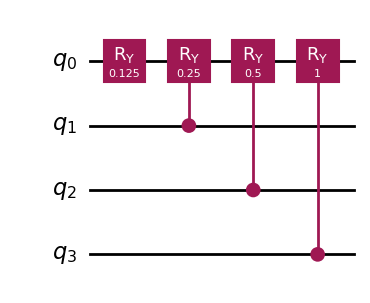

In [16]:
pure_affine.draw(output='mpl')

In [17]:
measure_affine = add_measurement(pure_affine)

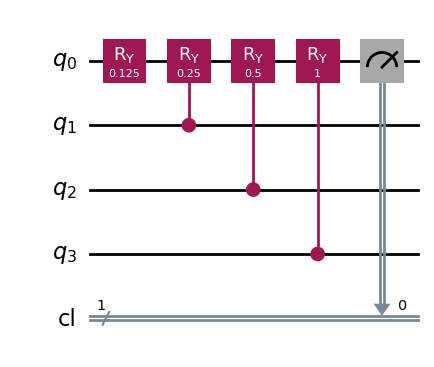

In [18]:
measure_affine.draw(output='mpl')

Creation of a method `initializer`$(qc,i)$ that takes as an input a quantum circuit $qc$ consisting of $n$ qubits and an integer $0\leq i \leq 2^{n} -1$, and creates a new quantum circuit in which the initial state is $|i\rangle$.

In [19]:
def initializer(qc, i):
    """
    Initialize the quantum circuit with the state |i>.
    :param qc: Quantum circuit
    :param i: State to initialize the circuit with
    :return: Quantum circuit with initialization
    """
    n = qc.num_qubits
    new_qc = QuantumCircuit(qc.num_qubits)
    binary_i = format(i, f'0{n}b')
    
    for qubit_idx in range(n):
        if binary_i[n - qubit_idx - 1] == '1':
            new_qc.x(qubit_idx + 1)
            
    new_qc = new_qc.compose(qc)
    return new_qc


We provide below a method `compare_values`$(n,a,b,d,i)$ that compares the expected value 
$$d\cdot\left(f(i)-\frac{1}{2}\right) + \frac{1}{2} = d\cdot\left(a+i\cdot b - \frac{1}{2}\right) + \frac{1}{2}$$
with the probability of measuring value $1$ in the constructed circuit. The method prints the expected value, the probability of measuring the value $1$ and the relative error between both.

This method is in charge of:
- Invoking `convert_affine` to get the appropriate parameters for the encoded affine function
- Creating the initial circuit (`encode_affine_function`)
- Invoking the `initializer` to set the desired initial state
- Adding a classical bit to measure the first qubit (`add_measurement` method) and using the `get_one_prob` method to compute the probability of measuring the value $1$

In [20]:
def compare_values(n, a, b, d, i):
    a_out, b_out = convert_affine(a, b, d)
    encoded_qc = encode_affine_function(n, a_out, b_out)
    initialized_qc = initializer(encoded_qc,i)
    measured_qc = add_measurement(initialized_qc)
    output_prob = get_one_prob(measured_qc, 10000)
    expected_value = d*(a+b*i -0.5) + 0.5
    relative_error =(expected_value-output_prob)/expected_value
    print(f'Expected value: {expected_value}, measured output: {output_prob}, relative error: {relative_error:.2%}')

In [21]:
def compare_all_values(n, a, b, d):
    for i in range(2**n):
        compare_values(n, a, b, d, i)

In [22]:
compare_all_values(n_test, a_test, b_test, d_test)

Expected value: 0.45625, measured output: 0.464, relative error: -1.70%
Expected value: 0.46875, measured output: 0.4744, relative error: -1.21%
Expected value: 0.48125, measured output: 0.4801, relative error: 0.24%
Expected value: 0.49375, measured output: 0.5024, relative error: -1.75%
Expected value: 0.50625, measured output: 0.4998, relative error: 1.27%
Expected value: 0.51875, measured output: 0.5256, relative error: -1.32%
Expected value: 0.53125, measured output: 0.539, relative error: -1.46%
Expected value: 0.54375, measured output: 0.5476, relative error: -0.71%


# A quantum circuit for integer comparison

The goal of this part is to construct a circuit of size $n$, parameterized by an integer $0\leq L \leq 2^n-1$, that permits to detect whether a given state $|i\rangle$ is such that $i < L$ or $i\geq L$.

## Creation of the 'or' gate

Definition of a method `or_gate`() that constructs a quantum circuit representing an *or* gate using the method described in the exercise sheet. The resulting circuit can be used as a standard gate thanks to the `to_gate()` method. It will be necessary to invoke the `transpile` method before measurement outcomes can be computed.

In [23]:
def or_gate():
    """
    Construct a quantum circuit for the OR gate.
    :return: Quantum circuit for the OR gate
    """
    qc = QuantumCircuit(3)
    qc.x(range(3))
    qc.ccx(0, 1, 2)
    qc.x(range(2))
    return qc


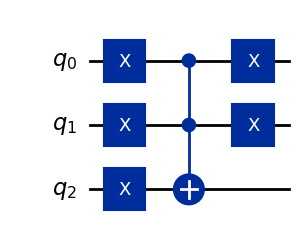

In [24]:
or_gate().draw(output='mpl')

We can verify that the *or* gate has the appropriate behavior by computing the probabilities of measuring a $1$ on qubit $2$ for different initial states.


**Useful methods**: 
- The `initialize` method defined above.
- The `to_gate()` instruction can be used to convert a circuit into a gate.
- The `transpile()` instruction allows the AerSimulator to convert the *or* gate back to known gates.

In [25]:
# Test the OR gate with different input states (0,0), (0,1), (1,0), (1,1)

# Convert the "OR gate" (quantum circuit) to a gate to be able to make simulations
gor_circuit = or_gate()
gor_gate = gor_circuit.to_gate()

def test_or_gate():
    """
    Test the OR gate with different input states.
    :return: Results of the OR gate for different input states
    """
    simulator = AerSimulator() 
    
    results = {}
    
    for state in [(0,0), (0,1), (1,0), (1,1)]:
        qc = QuantumCircuit(3, 1)
        
        if state[0]:
            qc.x(0)
        if state[1]:
            qc.x(1)
        
        qc.append(gor_gate, [0, 1, 2])
        
        qc.measure(2, 0)
        
        transpiled_qc = transpile(qc, simulator)
        result = simulator.run(transpiled_qc, shots=1024).result()
        counts = result.get_counts()
        
        results[state] = counts
        
    return results

# Test the OR gate
or_results = test_or_gate()

# Print the results
for state, counts in or_results.items():
    print(f"Input {state}: {counts}")


Input (0, 0): {'0': 1024}
Input (0, 1): {'1': 1024}
Input (1, 0): {'1': 1024}
Input (1, 1): {'1': 1024}


## Construction of the comparator circuit

Definition of a `make_comparator`$(n,L)$ method that creates a circuit $q$ of size $2n$ such that, when state $|i\rangle \otimes |0^n\rangle$ is fed as an input, we obtain a state $|x_{2n-1}\cdots x_0\rangle$ as an output with $|x_0\rangle = |0\rangle$ exactly when $i < L$. 

In [26]:
def make_comparator(n, L):
    """
    Create a comparator circuit of size 2n that compares |i> with L.
    :param n: Number of qubits to represent the input |i>
    :param L: Integer threshold for comparison
    :return: Quantum circuit implementing the comparator
    (Using the OR gate from the previous block + exercise 16)
    """
    qc = QuantumCircuit(2*n)
    
    # Calculate K^[n] = 2^n - L (two's complement of L)
    K_complement = (2**n) - L
    
    # Convert K_complement to binary representation
    # k[0] is least significant bit, k[n-1] is most significant bit
    k = [(K_complement >> i) & 1 for i in range(n)]
    
    # Apply Lc_0^(K) gate
    if k[0] == 1:
        qc.cx(n, n-1)  # CNOT[n, n-1]
    
    # Apply Lc_j^(K) gates for j in {1, ..., n-1}
    for j in range(1, n):
        # Define R_j = (n+j, n-j, n-j-1)
        control1 = n+j
        control2 = n-j
        target = n-j-1
        
        # Apply the appropriate gate based on k[j]
        if k[j] == 1:
            # OR[R_j] - using your provided or_gate function
            or_subcircuit = or_gate()
            qc.compose(or_subcircuit, [control1, control2, target], inplace=True)
        else:
            # CCNOT[R_j]
            qc.ccx(control1, control2, target)
    
    return qc    

An example when $n=3$ and $L=5$

In [27]:
cmp_qc = make_comparator(3, 5)

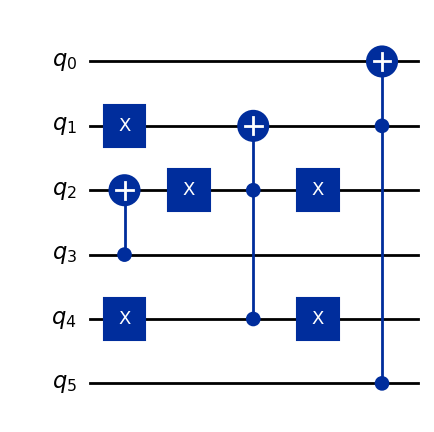

In [28]:
cmp_qc.draw(output='mpl')

Definition of a `check_comparison`$(n,L, nb)$ method that invokes the `make_comparator` method, iterates over $0\leq i\leq 2^n-1$ to initialize the circuit with state $|i\rangle \otimes |0^n\rangle$ and verifies that the measurement of the qubit at index $0$ returns the appropriate value for each value of $i$. Parameter $nb$ represents the number of shots used by the sampler to compute measurement outcome statistics.

In [29]:
def check_comparison(n, L, numshots):
    comp_qc = make_comparator(n, L)
    #line below useless?
    simulator = AerSimulator(method='statevector')
    sampler = SamplerV2()   
    for i in range(2**n):
        qr = QuantumRegister(2*n)
        qci = QuantumCircuit(qr)
        init = [0 for _ in range(2**n)]
        init[i] = 1
        qci.initialize(init, qr[n:2*n])
        res_qc = qci.compose(comp_qc)
        meas_qc = add_measurement(res_qc)
        qc = transpile(meas_qc, simulator)
        job = sampler.run([qc], shots=numshots)
        result = job.result()
        prob = result[0].data.cl.get_counts()
        print(f'Test if {i} >= {L}, measured output: {prob}')

In [30]:
check_comparison(4, 10, 1024)

Test if 0 >= 10, measured output: {'0': 1024}
Test if 1 >= 10, measured output: {'0': 1024}
Test if 2 >= 10, measured output: {'0': 1024}
Test if 3 >= 10, measured output: {'0': 1024}
Test if 4 >= 10, measured output: {'0': 1024}
Test if 5 >= 10, measured output: {'0': 1024}
Test if 6 >= 10, measured output: {'0': 1024}
Test if 7 >= 10, measured output: {'0': 1024}
Test if 8 >= 10, measured output: {'0': 1024}
Test if 9 >= 10, measured output: {'0': 1024}
Test if 10 >= 10, measured output: {'1': 1024}
Test if 11 >= 10, measured output: {'1': 1024}
Test if 12 >= 10, measured output: {'1': 1024}
Test if 13 >= 10, measured output: {'1': 1024}
Test if 14 >= 10, measured output: {'1': 1024}
Test if 15 >= 10, measured output: {'1': 1024}


# Storing a probability distribution in a quantum state

The goal of this part is to design a circuit that permits to store a probability distribution in a quantum state.

## Case where $n=2$

We begin with the simple case where $n=2$. The cell below constructs a circuit permitting to store the probability distribution in a quantum state (with a single qubit). 

In [31]:
def make_basic_qc(p):
    qreg = QuantumRegister(1)
    qc =  QuantumCircuit(qreg)
    theta = 2*math.acos(math.sqrt(p))
    qc.ry(theta, 0)
    return qc 

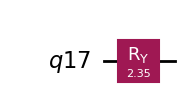

In [32]:
make_basic_qc(0.15).draw(output='mpl')

In [33]:
def get_state_probabilities(qc):
  n = qc.num_qubits
  statevector = Statevector(qc)
  probabilities = {}
  for i in range(2**n):
    state = bin(i)[2:].zfill(n)
    probabilities[state] = abs(statevector[i])**2  
  return probabilities

In [34]:
get_state_probabilities(make_basic_qc(0.15))

{'0': np.float64(0.1499999999999999), '1': np.float64(0.8500000000000001)}

The probability of getting the outcome $0$ is close to $p$, likewise for $1$ and $1-p$.

## Circuit for an arbitrary value of $n$.

### Generation of the final prices grid

Definition of a method `make_final_price_grid`$(n, \mathrm{price\_dict}, m)$ that generates a regular grid with size $2^n$ of final prices ranging between $\max\left(0, \overline{S} - m\cdot \sigma\right)$ and $\overline{S} + m\cdot \sigma$. This method is based on the `linspace` method from **numpy**.

In [35]:

def make_final_price_grid(n, price_dict, m):
    """
    Generate a regular grid of final prices.

    :param n: Number of qubits (determines the grid size as 2^n)
    :param price_dict: Dictionary containing the financial characteristics
    :param m: Number of standard deviations to consider for the grid bounds
    :return: Regular grid of final prices
    """
    S0 = price_dict['S0']
    sigma = price_dict['sigma']
    T = price_dict['T']
    r = price_dict['r']
    
    # Compute the \overline{S} price
    mean_price = S0 * np.exp((r - 0.5 * sigma**2) * T)
    
    # Compute the bounds of the grid
    lower = max(0, mean_price - m * sigma)
    upper = mean_price + m * sigma
    
    # Generate the grid using linspace
    final_price_grid = np.linspace(lower, upper, 2**n)
    
    return final_price_grid

Definition of a method `align`$(n, K, \mathrm{price\_dict}, m)$ that returns the value $L$ such that $s_L$ is the projection of $K$ on the final price grid. 

In [36]:
def align(n, K, price_dict, m):
    """
    Find the L index that s_L is the projection of K on the grid.
    :param n: Number of qubits (size of the grid)
    :param K: Strike price
    :param price_dict: Dictionary containing the characteristics
    :param m: Number of standard deviations to consider for the grid bounds
    :return: Index L and the price s_L
    """
    price_grid = make_final_price_grid(n, price_dict, m)
    L = np.argmin(np.abs(price_grid - K))
    return L, price_grid[L]

Test of the discretization error by comparing the outputs of `compound_black_scholes_call` on an arbitrary strike and on its projection on the final price grid.

In [37]:
init_cpb = compound_black_scholes_call(price_dict, price_dict['S0'])
disc_cpb = compound_black_scholes_call(price_dict, align(5, price_dict['S0'], price_dict, 3)[1])

In [38]:
print(f'init: {init_cpb}, disc: {disc_cpb}, error: {(init_cpb-disc_cpb)/init_cpb:.2%}')

init: 0.21972792899401578, disc: 0.2181400569021666, error: 0.72%


### Generation of the probability values

Definition of a method `make_probability_distribution` that returns a *last prices* grid and the corresponding value of each $p_i$ for $0 \leq i < 2^n$. The arguments of this method are:
- $n$: the number of qubits under consideration
- $\mathrm{price\_dict}$: the dictionary with the mathematical characteristics of the underlying
- $m$: the number of standard deviations to consider for the minimum and maximum bounds of the grid

***Useful methods:*** 
$S_T$ is of the form $S_0e^{(r-\tfrac{\sigma^2}{2})T}\cdot Z$, where $Z \sim \mathrm{lognorm}(\sigma\sqrt{T})$. The lognormal distribution is available thanks to the `lognorm` method from `scipy.stats`. The `scale` parameter is to be set to $1$.

The probability values can be computed using the `cdf` method available on the lognormal distribution.

In [39]:
def make_probability_distribution(n, pr_dict, num_stddev):
    """
    Generate the probability distribution for the final stock prices.
    
    :param n: Number of qubits
    :param pr_dict: Dictionary with the financial characteristics
    """
    # Generate the log-normal distribution
    S0 = pr_dict['S0']
    r = pr_dict['r']
    T = pr_dict['T']
    sigma = pr_dict['sigma']
    
    lognorm_dist = lognorm(sigma*np.sqrt(T), scale=1)
    
    final_prices = make_final_price_grid(n, pr_dict, num_stddev)
    sm = final_prices[0]
    sM = final_prices[-1]
    
    extended_prices = np.append(final_prices, sM + (sM - sm) / (2**n - 1))
    Z = extended_prices / S0 * np.exp((r - 0.5 * sigma**2) * T)    
    cdf_values = lognorm_dist.cdf(Z)
    prob_distribs = np.diff(cdf_values) / np.sum(np.diff(cdf_values))
    
    return final_prices, prob_distribs


## Validation of the probability distribution, comparison of the Black-Scholes approximation

In [40]:
# Arbitrary value for n, will afterward be the size of the quantum circuit
n_prob = 10
n_stddev_prob = 4

Verification that the generated distribution sums to $1$.

In [41]:
final_prices, prob_distribs = make_probability_distribution(n_prob, price_dict, n_stddev_prob)
np.sum(prob_distribs)

np.float64(1.0)

Plot the generated distribution against the final price grid.

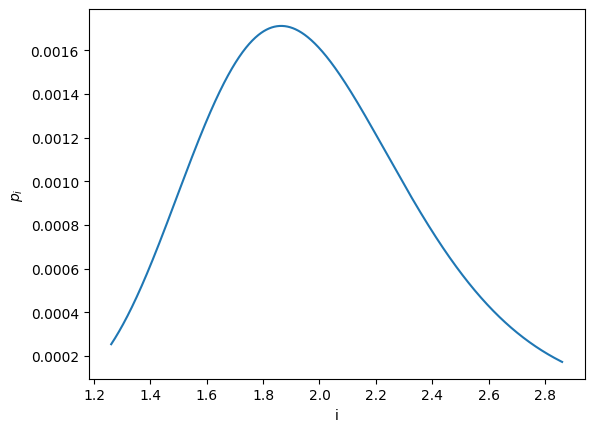

In [42]:
plt.plot(final_prices, prob_distribs)
plt.xlabel('i')
plt.ylabel('$p_i$')
plt.show()

Compare the compounded Black-Scholes price of an option with the approximation of the expectation 
$$\mathbb{E}\left[(S_T - s_L)_+\right] \approx \sum_{i=0}^{2^n-1}p_i\cdot(s_i - s_L)_+.$$

In [43]:
def expectation_cmp(n, L, price_dict, n_stddev):
    last_prices, prob_distribs = make_probability_distribution(n, price_dict, n_stddev)
    sL = last_prices[L]
    sum = 0
    for i in range(0, 2**n):        
        sum += (last_prices[i] - sL)*prob_distribs[i]*(i>=L)
    bs = compound_black_scholes_call(price_dict, sL)
    return {'bs': bs, 'sum': sum, 'strike': sL}

In [44]:
def get_all_expect_comp(n, price_dict, num_stddev, num_points):
    res = []
    for L in range(0, 2**n,int(2**n/num_points)):
        ex_cmp = expectation_cmp(n, L, price_dict, num_stddev)
        print(f'L: {L} (strike {ex_cmp["strike"]})')
        res.append(ex_cmp)
    return res

In [45]:
res = get_all_expect_comp(n_prob, price_dict,n_stddev_prob, 20)

L: 0 (strike 1.2609090679070338)
L: 51 (strike 1.340674463801462)
L: 102 (strike 1.42043985969589)
L: 153 (strike 1.5002052555903183)
L: 204 (strike 1.5799706514847465)
L: 255 (strike 1.6597360473791747)
L: 306 (strike 1.739501443273603)
L: 357 (strike 1.819266839168031)
L: 408 (strike 1.899032235062459)
L: 459 (strike 1.9787976309568873)
L: 510 (strike 2.0585630268513153)
L: 561 (strike 2.1383284227457438)
L: 612 (strike 2.2180938186401717)
L: 663 (strike 2.2978592145345997)
L: 714 (strike 2.377624610429028)
L: 765 (strike 2.4573900063234566)
L: 816 (strike 2.537155402217884)
L: 867 (strike 2.6169207981123126)
L: 918 (strike 2.696686194006741)
L: 969 (strike 2.776451589901169)
L: 1020 (strike 2.856216985795597)


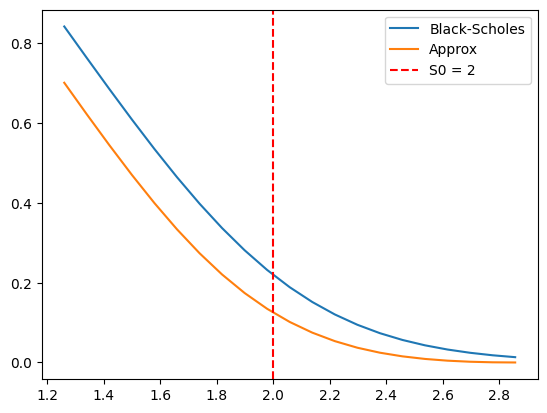

In [46]:
resbs = [x['bs'] for x in res]
ressum = [x['sum'] for x in res]
strikes = [x['strike'] for x in res]
xcoord = price_dict['S0']
plt.plot(strikes, resbs, label='Black-Scholes')
plt.plot(strikes, ressum, label='Approx')
plt.axvline(x=xcoord, color='r', linestyle='--', label=f'S0 = {xcoord}')
plt.legend()
plt.show()

In [47]:
abs_errors = [(x['sum'] - x['bs']) for x in res]

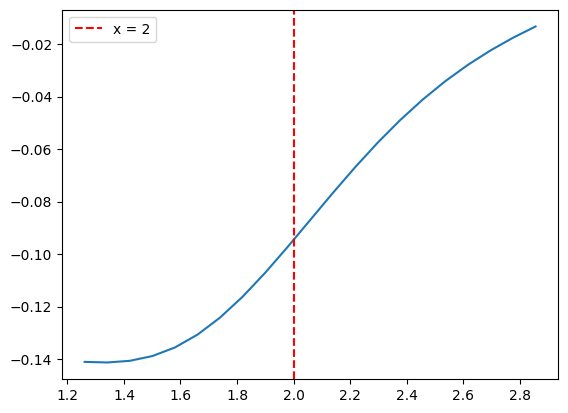

In [48]:
plt.plot(strikes, abs_errors)
xcoord = price_dict['S0']
plt.axvline(x=xcoord, color='r', linestyle='--', label=f'x = {xcoord}')
plt.legend()
plt.show()

## Recursive distribution computations

Computation of the values $q_w$ and $\theta_w$. The values of $q_w$ (resp. $\theta_w$) where $w$ is of length $m$ are stored in a dictionnary for which each key is a string of length $m$. The dictionnaries with the values of $q$ (resp. $\theta$) for $1 \leq m \leq n$ are stored in a dictionnary `DictQ` (resp. `DictTheta`).

Definition of a function `generate_binary_strings`$(n)$ that takes a parameter $n$ and outputs a list of all binary strings of length $n$.

Useful method: `product` from the `itertools` package

In [49]:
from itertools import product

def generate_binary_strings(n):
    """Generate all binary strings of length n."""
    binary_strings = [''.join(map(str, p)) for p in product([0, 1], repeat=n)]
    return binary_strings

Definition of a method `make_dict_at_n` that creates the dictionary containing the values $q_w$ where $w$ is of length $n$. This method has two parameters:
- the value of $n$
- the probability distribution under consideration

In [50]:
def make_dict_at_n(n, prob_distribs):
    """
    Create a dictionary mapping binary strings to their probability distributions.
    """
    binary_strings = generate_binary_strings(n)
    dict_at_n = {}
    for i, binary_string in enumerate(binary_strings):
        dict_at_n[binary_string] = prob_distribs[i]
    return dict_at_n

In [51]:
dict_pn = make_dict_at_n(n_prob, prob_distribs)

In [52]:
dict_pn

{'0000000000': np.float64(0.00025386041225833626),
 '0000000001': np.float64(0.0002569459405162984),
 '0000000010': np.float64(0.00026005512429244654),
 '0000000011': np.float64(0.00026318796381703124),
 '0000000100': np.float64(0.0002663444570117629),
 '0000000101': np.float64(0.00026952459947980997),
 '0000000110': np.float64(0.00027272838449500096),
 '0000000111': np.float64(0.0002759558029920474),
 '0000001000': np.float64(0.00027920684355751236),
 '0000001001': np.float64(0.0002824814924198195),
 '0000001010': np.float64(0.0002857797334413295),
 '0000001011': np.float64(0.0002891015481093445),
 '0000001100': np.float64(0.0002924469155281663),
 '0000001101': np.float64(0.00029581581241173755),
 '0000001110': np.float64(0.0002992082130758729),
 '0000001111': np.float64(0.00030262408943188495),
 '0000010000': np.float64(0.00030606341097948577),
 '0000010001': np.float64(0.0003095261448011035),
 '0000010010': np.float64(0.0003130122555559967),
 '0000010011': np.float64(0.0003165217054

Definition of a method `make_all_dictQ` that iterates from $n-1$ to $1$ to generate all the required probability distributions. Note that the set of keys in the generated dictionary is $\{1, \ldots, n\}$. This method has two parameters:
- the value of $n$
- the dictionary containing the probability distribution at level $n$ (generated by `make_dict_at_n`)

In [53]:
def make_all_dictQ(n, probs_dict_n):
    """Generate all dictionaries Q for all n."""

    all_probs_dicts = {n: probs_dict_n}
    
    for length in range(n-1, 0, -1):
        binary_strings = generate_binary_strings(length)
        current_dict = {}
        for binary_string in binary_strings:
            current_dict[binary_string] = (all_probs_dicts[length + 1][binary_string + '0'] + all_probs_dicts[length + 1][binary_string + '1'])
        all_probs_dicts[length] = current_dict
    return all_probs_dicts

In [54]:
dict_all_q = make_all_dictQ(n_prob, dict_pn)

In [55]:
dict_all_q

{10: {'0000000000': np.float64(0.00025386041225833626),
  '0000000001': np.float64(0.0002569459405162984),
  '0000000010': np.float64(0.00026005512429244654),
  '0000000011': np.float64(0.00026318796381703124),
  '0000000100': np.float64(0.0002663444570117629),
  '0000000101': np.float64(0.00026952459947980997),
  '0000000110': np.float64(0.00027272838449500096),
  '0000000111': np.float64(0.0002759558029920474),
  '0000001000': np.float64(0.00027920684355751236),
  '0000001001': np.float64(0.0002824814924198195),
  '0000001010': np.float64(0.0002857797334413295),
  '0000001011': np.float64(0.0002891015481093445),
  '0000001100': np.float64(0.0002924469155281663),
  '0000001101': np.float64(0.00029581581241173755),
  '0000001110': np.float64(0.0002992082130758729),
  '0000001111': np.float64(0.00030262408943188495),
  '0000010000': np.float64(0.00030606341097948577),
  '0000010001': np.float64(0.0003095261448011035),
  '0000010010': np.float64(0.0003130122555559967),
  '0000010011': np

Definition of a method `make_all_dictTheta` that iterates from $0$ to $n-1$ to generate all the required angles. Note that the set of keys in the generated dictionary is $\{0, \ldots, n-1\}$. This method has a single parameter: the dictionary generated by `make_all_dictQ`.

For the sake of convenience, the element at key $0$ in the generated dictionary will be the angle $\theta^{[0]}_\varepsilon$ instead of a dictionary containing this angle (with the empty string as a key).

In [56]:
def make_all_dictTheta(all_prob_dicts):
    """Compute theta angles for all binary strings up to length n."""
    n = max(all_prob_dicts.keys())
    theta_all_dict = {0: {'': 2 * np.arccos(np.sqrt(all_prob_dicts[1]['0']))}}
    for length in range(1, n):
        binary_strings = generate_binary_strings(length)
        theta_dict = {}
        for binary_string in binary_strings:
            extension_with_zero = binary_string + '0'
            theta_dict[binary_string] = 2 * np.arccos(np.sqrt(all_prob_dicts[length+1][extension_with_zero] / all_prob_dicts[length][binary_string]))
        theta_all_dict[length] = theta_dict
    return theta_all_dict

In [57]:
dict_all_theta = make_all_dictTheta(dict_all_q)

In [58]:
dict_all_theta

{0: {'': np.float64(1.3093099033566995)},
 1: {'0': np.float64(1.9042911386671828), '1': np.float64(1.0620781283848943)},
 2: {'00': np.float64(1.9666126020072876),
  '01': np.float64(1.5768433868330285),
  '10': np.float64(1.3633756897066225),
  '11': np.float64(1.2455613596294213)},
 3: {'000': np.float64(1.8536830342545068),
  '001': np.float64(1.7122061510041158),
  '010': np.float64(1.6116034343211938),
  '011': np.float64(1.5390835592087566),
  '100': np.float64(1.4859630514079443),
  '101': np.float64(1.4464699135682249),
  '110': np.float64(1.416740206773225),
  '111': np.float64(1.394142714555639)},
 4: {'0000': np.float64(1.7377065817478656),
  '0001': np.float64(1.6938492780392638),
  '0010': np.float64(1.6576278218860399),
  '0011': np.float64(1.627478906979119),
  '0100': np.float64(1.6022022262932656),
  '0101': np.float64(1.580869726867983),
  '0110': np.float64(1.5627578470812176),
  '0111': np.float64(1.5472974423024608),
  '1000': np.float64(1.5340368320831639),
  '10

Definition of a method `make_qc_for_dict` that creates the general quantum circuit for the storage of a quantum distribution. This method has a unique parameter: the dictionary of rotation angles (generated by `make_all_dictTheta`).

Some useful concepts and methods from Qiskit:
- `RYGate` for $y$-rotation gates that are potentially controlled
- `control`: the method to create the controlled version of a quantum gate. This method takes as parameters the number of control qubits, and possibly the state of the control qubits that will trigger the gate (`ctrl_state`).

In [59]:
def make_qc_for_dict(dict_all_theta):
    """Create a quantum circuit that loads a probability distribution using rotation angles."""
    n = max(dict_all_theta.keys()) + 1
    qc = QuantumCircuit(n)
    qc.ry(dict_all_theta[0][''], n-1)
    for level in range(1, n):
        binary_strings = generate_binary_strings(level)
        for binary_string in binary_strings:
            theta = dict_all_theta[level][binary_string]
            ry_gate = RYGate(theta)
            ctrl_gate = ry_gate.control(level, ctrl_state=binary_string)
            qc.append(ctrl_gate, [n-i-1 for i in range(level+1)])
    return qc

In [60]:
prob_distrib_qc = make_qc_for_dict(dict_all_theta)

In [61]:
#prob_distrib_qc.draw(output='mpl')

## Validation

In [62]:
circ_prob_distrib = get_state_probabilities(prob_distrib_qc)

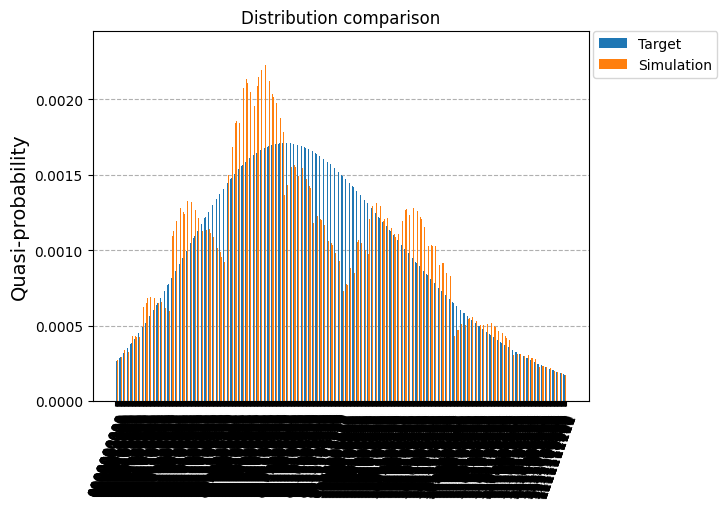

In [63]:
legend=["Target", "Simulation"]
plot_histogram([dict_pn, circ_prob_distrib], legend=legend, title="Distribution comparison", bar_labels=False)

Global method that constructs a circuit that stores the probability distribution in a quantum state

In [64]:
def make_distribution_circuit(n, pricing_dict, num_stddev):
    _ ,prob_distrib = make_probability_distribution(n, pricing_dict, num_stddev)
    dict_pn = make_dict_at_n(n, prob_distrib)
    dict_all_q = make_all_dictQ(n, dict_pn)
    dict_all_theta = make_all_dictTheta(dict_all_q)
    res = make_qc_for_dict(dict_all_theta)
    return res

# Full integration

In [65]:
circ_dict = {'n': 3, 'd': 0.01, 'num_stddev': 3, 'm': 3}
K = 2.0

## Creation of the affine functions $f_0$ and $f_1$

Computation of the values $a_i$ and $b_i$ such that $f_i = a_i + b_i\cdot i$.

In [66]:
# Loading of parameters
n = circ_dict['n']
d = circ_dict['d']
num_stddev = circ_dict['num_stddev']
m = circ_dict['m']
L, sL = align(n, K, price_dict, m)
sm, sM = final_prices[0], final_prices[-1]

Comparison of the expectation to estimate with the expectation of its sine approximation.

In [67]:
def compare_expect(circ_dict, price_dict, K):
    n = circ_dict['n']
    d = circ_dict['d']
    num_stddev = circ_dict['num_stddev']
    m = circ_dict['m']

    final_prices, prob_distribs = make_probability_distribution(n, price_dict, num_stddev)
    L, sL = align(n, K, price_dict, m)

    mean_f = 0
    for i in range(2**n):
        payoff = max(final_prices[i] - K, 0)
        mean_f += payoff * prob_distribs[i]
    a = 1 / (2**n)
    b = 0.5 - a * L

    a_converted, b_converted = convert_affine(a, b, d)

    mean_sin = 0
    for i in range(2**n):
        sin_approx = np.sin(a_converted * i + b_converted)**2
        mean_sin += sin_approx * prob_distribs[i]

    return mean_f, mean_sin

In [68]:
expect, sin_expect = compare_expect(circ_dict, price_dict, K)

In [69]:
expect, sin_expect

(np.float64(0.09613392911644539), np.float64(0.4958203384368959))

Definition of methods to construct the circuits for $f_0$ and $f_1$ using the `encode_affine_function` method.

In [70]:
def make_f0_circuit(circ_dict):
   n = circ_dict['n']
   d = circ_dict['d']
   a = np.pi/4 - d/2
   b = 0
   fc = encode_affine_function(0, a, b)
   return fc

def make_f1_circuit(circ_dict, price_dict, K):
   n = circ_dict['n']
   d = circ_dict['d']
   num_stddev = circ_dict['num_stddev']
   final_prices, _ = make_probability_distribution(n, price_dict, num_stddev)
   sm, sM = final_prices[0], final_prices[-1]
   L, sL = align(n, K, price_dict, num_stddev)
   a = d * (sM - sm) / ((sM - sL) * (2**n - 1)) * (-L)
   b = d * (sM - sm) / ((sM - sL) * (2**n - 1))
   f1_circuit = encode_affine_function(n, a, b)
   
   return f1_circuit

## Comparison circuit

Construction of the comparison circuit for a given strike price.

In [71]:
def make_comparison_circuit(circ_dict, price_dict, K):
    n = circ_dict['n']
    m = circ_dict['m']
    L, _ = align(n, K, price_dict, m)
    comparator_circuit = make_comparator(n, L)
    circ_dict['comparator_circuit'] = comparator_circuit
    return comparator_circuit
    

In [72]:
cmp_qc = make_comparison_circuit(circ_dict, price_dict, K)

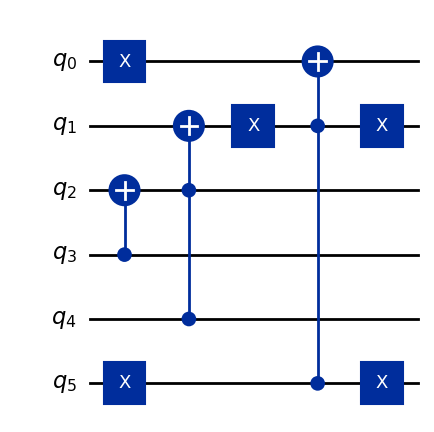

In [73]:
cmp_qc.draw('mpl')

## Integration

Global integration to construct the global circuit encoding the pricing problem in a quantum state.

In [74]:
def integration(option_params, market_params, strike_price):
    n_bits = option_params['n']
    m = option_params['m']
    num_stddev = option_params['num_stddev']
    
    f0_circuit = make_f0_circuit(option_params)
    f1_circuit = make_f1_circuit(option_params, market_params, strike_price)
    
    qr_aux = QuantumRegister(m, 'aux')
    qr_price = QuantumRegister(n_bits, 'price')
    qr_cmp = QuantumRegister(n_bits, 'cmp')
    qr_res = QuantumRegister(1, 'res')
    
    qc = QuantumCircuit(qr_aux, qr_price, qr_cmp, qr_res)
    
    dist_circuit = make_distribution_circuit(n_bits, market_params, num_stddev)
    qc.compose(dist_circuit, qr_price[:], inplace=True)

    L, _ = align(n_bits, strike_price, market_params, num_stddev)
    comp_circuit = make_comparator(n_bits, L)
    qc.compose(comp_circuit, qr_price[:] + qr_cmp[:], inplace=True)
    
    qc.compose(f0_circuit, qr_res[:], inplace=True)
    f1_qubits = qr_aux[:] + qr_price[:] + qr_cmp[:] + qr_res[:]
    
    for i, instruction in enumerate(f1_circuit.data):
        gate = instruction.operation
        qubits = instruction.qubits
        mapped_qubits = [f1_qubits[f1_circuit.find_bit(qubit).index] for qubit in qubits]
        qc.append(gate.control(1), [qr_cmp[n_bits-1]] + mapped_qubits)
    
    return qc

In [75]:
qc_pricer = integration(circ_dict, price_dict, K)

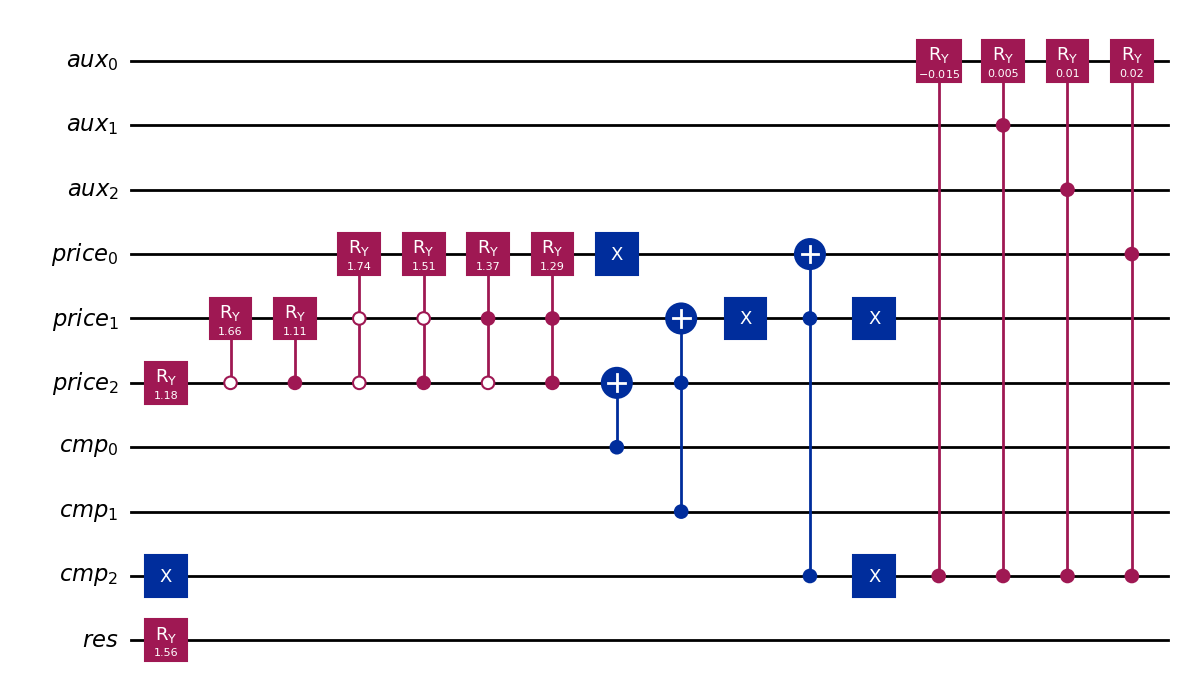

In [76]:
qc_pricer.draw('mpl')

In [77]:
def qae_eval(qc_pricer):
    obj_qubits = qc_pricer.find_bit(qc_pricer.qregs[3][0])
    problem = EstimationProblem(state_preparation=qc_pricer, objective_qubits=[obj_qubits.index]) 
    iae = IterativeAmplitudeEstimation(
        epsilon_target=0.01,  # Target accuracy
        alpha=0.05,  # Confidence level
    )
    result = iae.estimate(problem).estimation
    return result

In [78]:
res = qae_eval(qc_pricer)

/home/jeremie/Documents/quantum_pricing/.venv/lib/python3.12/site-packages/qiskit_algorithms/amplitude_estimators/iae.py:274: UserWarning: No sampler provided, defaulting to Sampler from qiskit.primitives
  warnings.warn("No sampler provided, defaulting to Sampler from qiskit.primitives")


In [79]:
print(f'sin_expect: {sin_expect}, res: {res}')

sin_expect: 0.4958203384368959, res: 0.4950000833329167


# Conclusion

In this notebook, we've implemented and compared classical and quantum approaches to option pricing. While the Black-Scholes formula provides an elegant closed-form solution for vanilla options, its application is limited when dealing with exotic derivatives or complex market conditions (even if here we've only price simple options: European call options).

## Key Findings

Both Monte Carlo and quantum approaches shine in these more complex scenarios. The quantum amplitude estimation (QAE) approach we've implemented demonstrates a theoretical advantage in convergence rate $O(M^{-\frac{2}{3}})$ compared to classical Monte Carlo $O(M^{-\frac{1}{2}})$, meaning fewer samples are needed to achieve the same accuracy.

This advantage becomes particularly valuable when pricing exotic derivatives where no closed-form solution exists


Our numerical experiments show promising results:
- Expected theoretical value: 0.4958203384368959
- Quantum algorithm result: 0.4950000833329167

This represents a relative error of approximately 0.16%, demonstrating that quantum methods can provide accurate option pricing with significantly fewer samples than classical approaches.

## Advantages of Quantum Methods
- **Improved asymptotic scaling**: Faster convergence as sample size increases
- **Adaptability to different pricing models**: This quantum notebook can be extended to various stochastic processes

## Current Limitations
- **Hardware constraints**: Current quantum computers have limited qubits and high noise levels. 
- **Overhead costs**: Preparation and measurement of quantum states introduce additional computational costs. (cf. the runtime for the grid and dictionaries...).